# Getting the data and installing the necessary dependencies

In [ ]:
!pip install tensorflow
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 8.6 MB/s eta 0:00:00


### Since the subset on Kaggle of ImageNet is 155GB we will download only the needed classes using this script wrote by a genius on github which downloads the classes based on its ID from a csv file , but first we need to specify the class names and get their IDs

In [ ]:
!git clone https://github.com/mf1024/ImageNet-Datasets-Downloader.git

Cloning into 'ImageNet-Datasets-Downloader'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 127 (delta 4), reused 6 (delta 2), pack-reused 113
Receiving objects: 100% (127/127), 1.58 MiB | 8.45 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import cv2
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
df = pd.read_csv('/content/ImageNet-Datasets-Downloader/classes_in_imagenet.csv')
df.head()

,synid,class_name,urls,flickr_urls
0,n00004475,organism,8,6
1,n00005787,benthos,1264,626
2,n00006024,heterotroph,1,0
3,n00006484,cell,1251,628
4,n00007846,person,1242,1138


In [ ]:
l =['zebra','antelope','bear','condor','manatee', 'giraffe','bison','bald eagle','alligator','cheetah']

In [ ]:
df = df[df['class_name'].isin(l)]


In [ ]:
df

,synid,class_name,urls,flickr_urls
852,n01614925,bald eagle,1263,1126
868,n01619536,condor,1175,1070
1092,n01698434,alligator,1347,914
2134,n02073831,manatee,1360,567
2441,n02130308,cheetah,1427,972
2444,n02131653,bear,1688,1155
3296,n02391049,zebra,1474,988
3375,n02410509,bison,1625,1111
3426,n02419796,antelope,1282,552
3500,n02439033,giraffe,1256,668


In [ ]:
ids = df['synid'].tolist()
for i in ids:
  print(i)


n01614925
n01619536
n01698434
n02073831
n02130308
n02131653
n02391049
n02410509
n02419796
n02439033


**Create a folder to hold our classes so we can later on load them by Keras's generator method flow_from_directory**

In [ ]:
!mkdir ImageNet

In [ ]:
!python ImageNet-Datasets-Downloader/downloader.py \
    -data_root /content/ImageNet \
    -use_class_list True \
    -class_list n01614925 n01619536 n01698434 n02073831 n02130308 n02131653 n02391049 n02410509 n02419796 n02439033 \
    -images_per_class 1000 

Picked the following clases:
['bald eagle', 'condor', 'alligator', 'manatee', 'cheetah', 'bear', 'zebra', 'bison', 'antelope', 'giraffe']
Scraping images for class "bald eagle"
Multiprocessing workers: 8

Scraping stats:
STATS For class is_flickr:
 tried 242.0 urls with 161.0 successes
66.52892561983471% success rate for is_flickr urls 
0.03190521720033255 seconds spent per is_flickr succesful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 242.0 urls with 161.0 successes
66.52892561983471% success rate for all urls 
0.031905686633187054 seconds spent per all succesful image download

Scraping stats:
STATS For class is_flickr:
 tried 492.0 urls with 360.0 successes
73.17073170731707% success rate for is_flickr urls 
0.02701026267475552 seconds spent per is_flickr succesful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 492.0 urls with 360.0 successes
73.17073170731707% s

# **ViT: Vision Transformer**

In [ ]:
from google.colab import files
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from keras.models import load_model
import pickle

**HyperParameters**

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
input_shape = (64, 64, 3)
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 
num_classes = 10

**Data Preperation**

In [ ]:
train_gen = ImageDataGenerator(
        1/255.,
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

test_gen =  ImageDataGenerator(
        1/255.,
        validation_split=0.20)

In [ ]:
train_generator = train_gen.flow_from_directory(
                  directory='/content/ImageNet/imagenet_images',
                  color_mode="rgb", # for coloured images
                  target_size = (image_size,image_size),
                  batch_size=batch_size, # number of images to extract from folder for every batch
                  class_mode="sparse", # classes to predict
                  seed=43 # to make the result reproducible
                  )


test_generator = test_gen.flow_from_directory(
                  directory='/content/ImageNet/imagenet_images',
                  color_mode="rgb", # for coloured images
                  batch_size=batch_size,# number of images to extract from folder for every batch
                  target_size = (image_size,image_size), 
                  shuffle = True,
                  class_mode="sparse", # classes to predict
                  seed=43 ,# to make the result reproducible
                  subset = "validation")

Found 6957 images belonging to 10 classes.
Found 1387 images belonging to 10 classes.


**Implement the MLP Layer**

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

**Implement patch creation as a layer**

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

**Let's display patches for a sample image**

/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Image size: 64 X 64
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


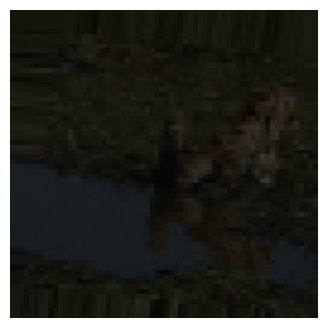

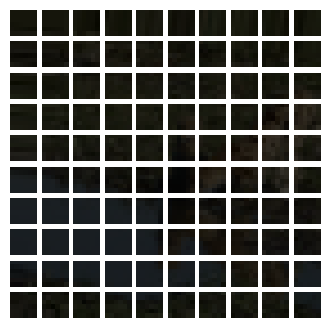

In [ ]:
x,y = train_generator.next()
plt.figure(figsize=(4, 4))
image = x[1,:]
plt.imshow(image.astype("uint8"))
plt.axis("off")


resized_image = tf.image.resize(
    tf.convert_to_tensor([x[1,:]]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify the outputs.
    logits = layers.Dense(10)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
vit_classifier = create_vit_classifier()

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)


early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
checkpoint_callback = ModelCheckpoint(filepath='VIT1.h5',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      monitor='val_loss',
                                      verbose=1)

tensorboard_callback = TensorBoard(log_dir='./logs')

vit_classifier.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        run_eagerly=True,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])


steps_per_epoch = len(train_generator)//batch_size

history =vit_classifier.fit(train_generator,validation_data = test_generator, batch_size = batch_size,epochs=num_epochs, callbacks=[tensorboard_callback,checkpoint_callback,early_stop])





Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 4.4396 - accuracy: 0.1430 - top-5-accuracy: 0.5919
Epoch 1: val_loss improved from inf to 2.12666, saving model to VIT1.h5
28/28 [==============================] - 56s 2s/step - loss: 4.4396 - accuracy: 0.1430 - top-5-accuracy: 0.5919 - val_loss: 2.1267 - val_accuracy: 0.1975 - val_top-5-accuracy: 0.7008
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 2.2123 - accuracy: 0.1718 - top-5-accuracy: 0.6617
Epoch 2: val_loss improved from 2.12666 to 2.08883, saving model to VIT1.h5
28/28 [==============================] - 82s 3s/step - loss: 2.2123 - accuracy: 0.1718 - top-5-accuracy: 0.6617 - val_loss: 2.0888 - val_accuracy: 0.2199 - val_top-5-accuracy: 0.7253
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 2.1514 - accuracy: 0.1889 - top-5-accuracy: 0.6856
Epoch 3: val_loss improved from 2.08883 to 2.07140, saving model to VIT1.h5
28/28 [==============================] - 72s 3s/st

In [ ]:
with open('history_first_model.pkl', 'wb') as f:
    pickle.dump(history.history, f)

**Plotting using Tensorboard**

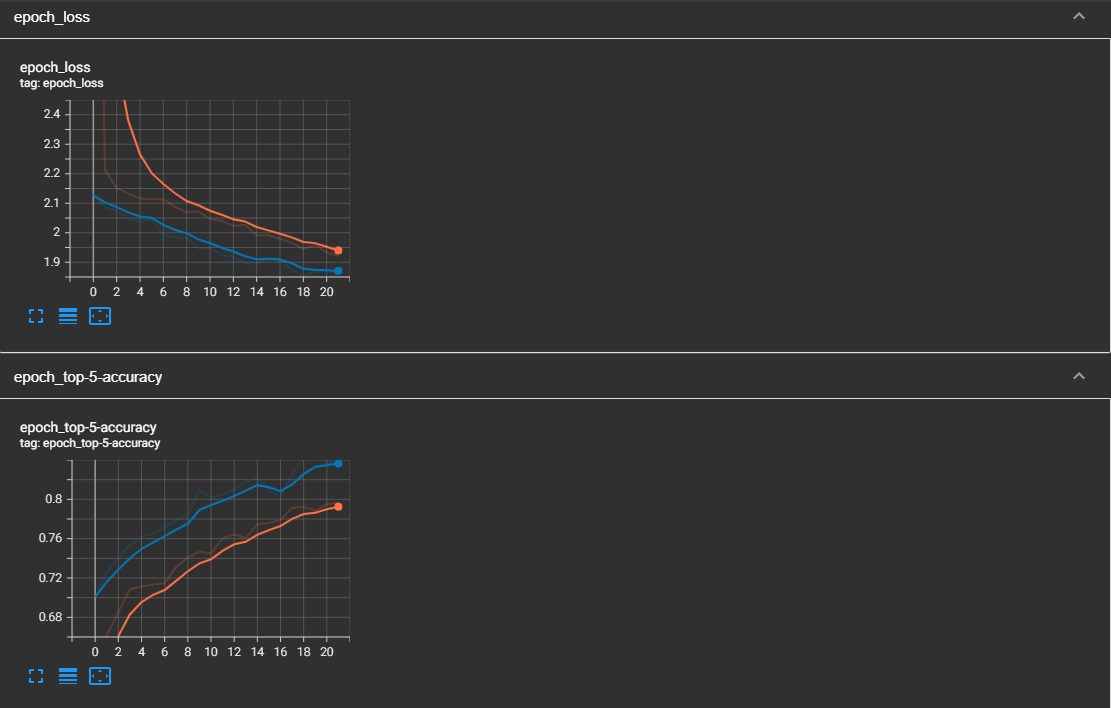

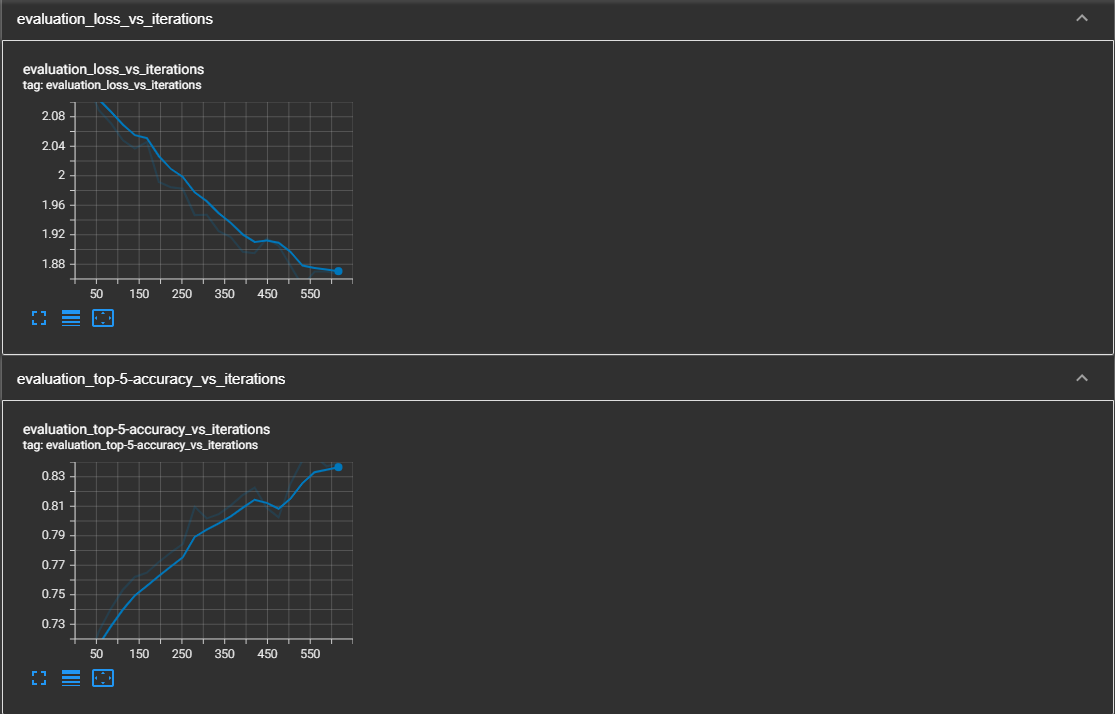

In [ ]:
baseline = create_vit_classifier()
baseline.load_weights('VIT1.h5')
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
baseline.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        run_eagerly=True,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

**Confusion Matrix & Classification Report Including all the Classification Metrics**

In [ ]:
from matplotlib.pyplot import figure
def eval_model(model):
    target_names = ['alligator','antelope','bald eagle','bear','bison','cheetah','condor','giraffe','manatee','zebra']
    
    con = [0,1,2,3,4,5,6,7,8,9]
    val_generator = test_gen.flow_from_directory(
                        directory='/content/ImageNet/imagenet_images',
                        color_mode="rgb", # for coloured images
                        target_size = (64,64), 
                        shuffle = False,
                        batch_size=1387,
                        class_mode="sparse",
                        classes=target_names , # classes to predict
                        seed=42 ,# to make the result reproducible
                        subset = "validation")

    model_preds = model.predict(val_generator)
    predicted_labels = np.argmax(model_preds, axis=1)
    true_labels = val_generator.labels

    print(classification_report(true_labels, predicted_labels, target_names=target_names))

    labels = np.unique(true_labels)
    cm = confusion_matrix(true_labels, predicted_labels ,labels=labels)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)

    # set axis labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    plt.show()

Found 1387 images belonging to 10 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1/1 [==============================] - 5s 5s/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   alligator       0.28      0.20      0.23       130
    antelope       0.00      0.00      0.00        82
  bald eagle       0.42      0.53      0.47       169
        bear       0.23      0.48      0.31       185
       bison       0.43      0.42      0.43       169
     cheetah       0.29      0.58      0.39       147
      condor       0.55      0.24      0.34       169
     giraffe       0.20      0.01      0.02        99
     manatee       0.80      0.27      0.41        88
       zebra       0.22      0.20      0.21       149

    accuracy                           0.33      1387
   macro avg       0.34      0.29      0.28      1387
weighted avg       0.35      0.33      0.30      1387



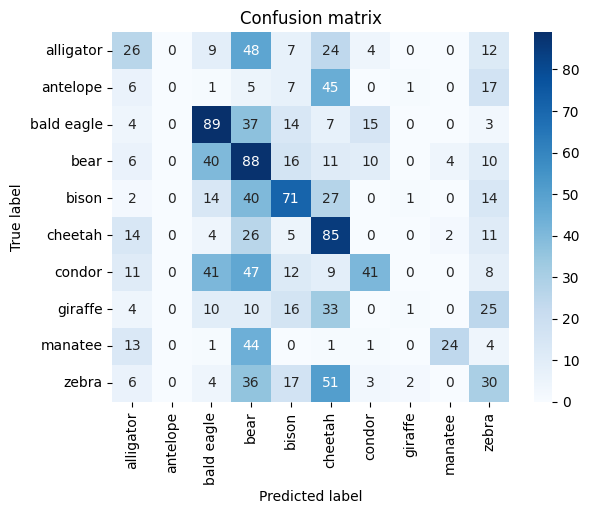

In [ ]:
eval_model(baseline)

In [ ]:

!zip -r /content/logs.zip /content/logs
files.download('/content/logs.zip')
files.download('/content/VIT1.h5')
files.download('/content/history_first_model.pkl')

updating: content/logs/ (stored 0%)
updating: content/logs/train/ (stored 0%)
updating: content/logs/train/events.out.tfevents.1681611153.1acab891f201.403.0.v2 (deflated 90%)
updating: content/logs/validation/ (stored 0%)
updating: content/logs/validation/events.out.tfevents.1681611203.1acab891f201.403.1.v2 (deflated 78%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Tuning Hyperprameters : Larger Learning Rate**

**Tuning Some Hyperparameters**
: We will try a larger learning rate for 100 epochs 

In [ ]:
################################
learning_rate = 0.1
################################
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
input_shape = (64, 64, 3)
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 
num_classes = 10

In [ ]:
vit_classifier = create_vit_classifier()

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

checkpoint_callback = ModelCheckpoint(filepath='VIT2(Larger_Learning_Rate).h5',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      monitor='val_loss',
                                      verbose=1)

tensorboard_callback = TensorBoard(log_dir='./logs2ndModel')

vit_classifier.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        run_eagerly=True,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])


steps_per_epoch = len(train_generator)//batch_size

history =vit_classifier.fit(train_generator,validation_data = test_generator, batch_size = batch_size,epochs=num_epochs, callbacks=[tensorboard_callback,checkpoint_callback,early_stop])


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 51971.3633 - accuracy: 0.1104 - top-5-accuracy: 0.5178
Epoch 1: val_loss improved from inf to 2.27408, saving model to VIT2(Larger_Learning_Rate).h5
28/28 [==============================] - 53s 2s/step - loss: 51971.3633 - accuracy: 0.1104 - top-5-accuracy: 0.5178 - val_loss: 2.2741 - val_accuracy: 0.1218 - val_top-5-accuracy: 0.6049
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 14.1387 - accuracy: 0.1317 - top-5-accuracy: 0.6049
Epoch 2: val_loss improved from 2.27408 to 2.26842, saving model to VIT2(Larger_Learning_Rate).h5
28/28 [==============================] - 49s 2s/step - loss: 14.1387 - accuracy: 0.1317 - top-5-accuracy: 0.6049 - val_loss: 2.2684 - val_accuracy: 0.1334 - val_top-5-accuracy: 0.6049
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 6.3248 - accuracy: 0.1340 - top-5-accuracy: 0.6044
Epoch 3: val_loss did not improve from 2.26842
28/28 [==================

In [ ]:
with open('history_second_model_w_large_LR.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
VITLR = create_vit_classifier()
VITLR.load_weights('/content/VIT2(Larger_Learning_Rate).h5')
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
VITLR.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        run_eagerly=True,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

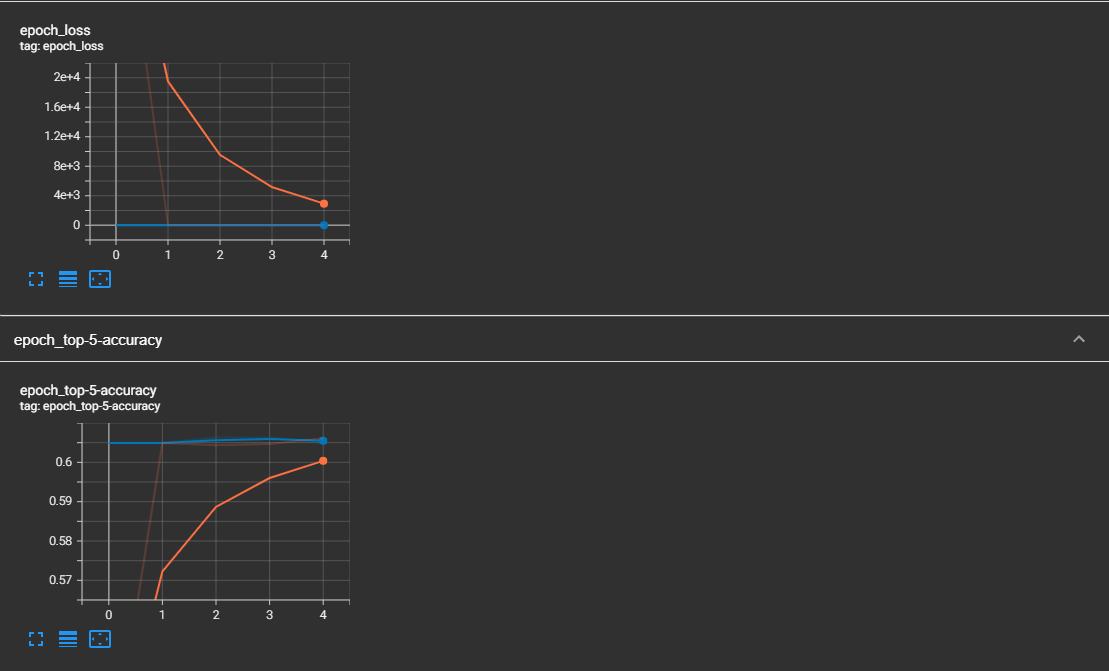

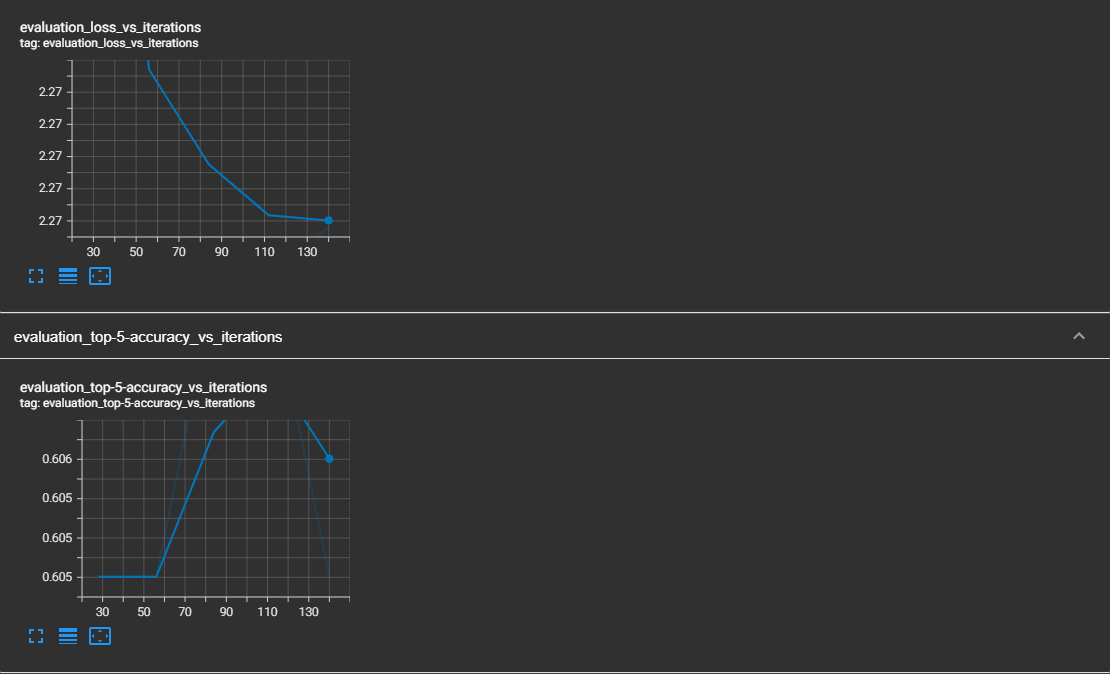

Found 1387 images belonging to 10 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1/1 [==============================] - 6s 6s/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   alligator       0.00      0.00      0.00       130
    antelope       0.00      0.00      0.00        82
  bald eagle       0.00      0.00      0.00       169
        bear       0.13      1.00      0.24       185
       bison       0.00      0.00      0.00       169
     cheetah       0.00      0.00      0.00       147
      condor       0.00      0.00      0.00       169
     giraffe       0.00      0.00      0.00        99
     manatee       0.00      0.00      0.00        88
       zebra       0.00      0.00      0.00       149

    accuracy                           0.13      1387
   macro avg       0.01      0.10      0.02      1387
weighted avg       0.02      0.13      0.03      1387



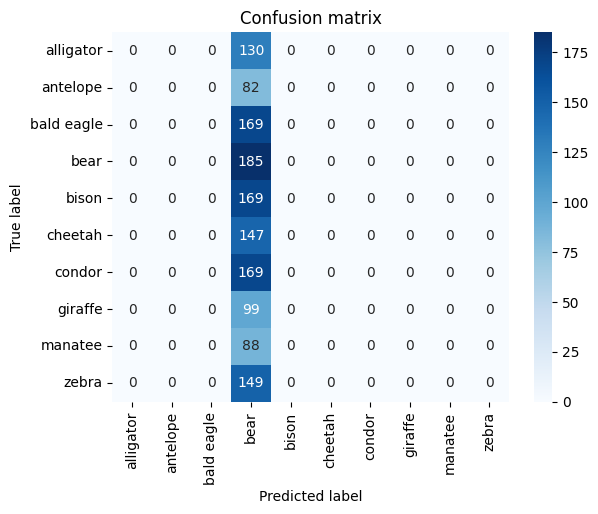

In [ ]:
eval_model(VITLR)


In [ ]:
!zip -r /content/logs2ndModel.zip /content/logs2ndModel
files.download('/content/logs2ndModel.zip')
files.download('/content/VIT2(Larger_Learning_Rate).h5')
files.download('/content/history_second_model_w_large_LR.pkl')

  adding: content/logs2ndModel/ (stored 0%)
  adding: content/logs2ndModel/train/ (stored 0%)
  adding: content/logs2ndModel/train/events.out.tfevents.1681615639.1acab891f201.403.2.v2 (deflated 92%)
  adding: content/logs2ndModel/validation/ (stored 0%)
  adding: content/logs2ndModel/validation/events.out.tfevents.1681615686.1acab891f201.403.3.v2 (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  **Tuning Hyperprameters : Changing Number of MLP Units**

**Changing The Number of MLP**
: We will try a smaller number 

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
input_shape = (64, 64, 3)
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
####################################
mlp_head_units = [512, 1024] 
#####################################
num_classes = 10

In [ ]:
vit_classifier = create_vit_classifier()

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

checkpoint_callback = ModelCheckpoint(filepath='VIT2(Smaller_MLP).h5',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      monitor='val_loss',
                                      verbose=1)

tensorboard_callback = TensorBoard(log_dir='./logsVIT2(Smaller_MLP)')
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
vit_classifier.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        run_eagerly=True,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])


steps_per_epoch = len(train_generator)//batch_size

history =vit_classifier.fit(train_generator,validation_data = test_generator, batch_size = batch_size,epochs=num_epochs, callbacks=[tensorboard_callback,checkpoint_callback,early_stop])

/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 2.7040 - accuracy: 0.1366 - top-5-accuracy: 0.5864
Epoch 1: val_loss improved from inf to 2.18676, saving model to VIT2(Smaller_MLP).h5
28/28 [==============================] - 53s 2s/step - loss: 2.7040 - accuracy: 0.1366 - top-5-accuracy: 0.5864 - val_loss: 2.1868 - val_accuracy: 0.2134 - val_top-5-accuracy: 0.6460
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 2.2077 - accuracy: 0.1656 - top-5-accuracy: 0.6600
Epoch 2: val_loss improved from 2.18676 to 2.10036, saving model to VIT2(Smaller_MLP).h5
28/28 [==============================] - 56s 2s/step - loss: 2.2077 - accuracy: 0.1656 - top-5-accuracy: 0.6600 - val_loss: 2.1004 - val_accuracy: 0.2192 - val_top-5-accuracy: 0.7239
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 2.1783 - accuracy: 0.1810 - top-5-accuracy: 0.6764
Epoch 3: val_loss did not improve from 2.10036
28/28 [==============================] - 49s 2s/step 

In [ ]:
with open('history_VIT2(Smaller_MLP).pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
VITE = create_vit_classifier()
VITE.load_weights('/content/VIT2(Smaller_MLP).h5')
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
VITE.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        run_eagerly=True,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

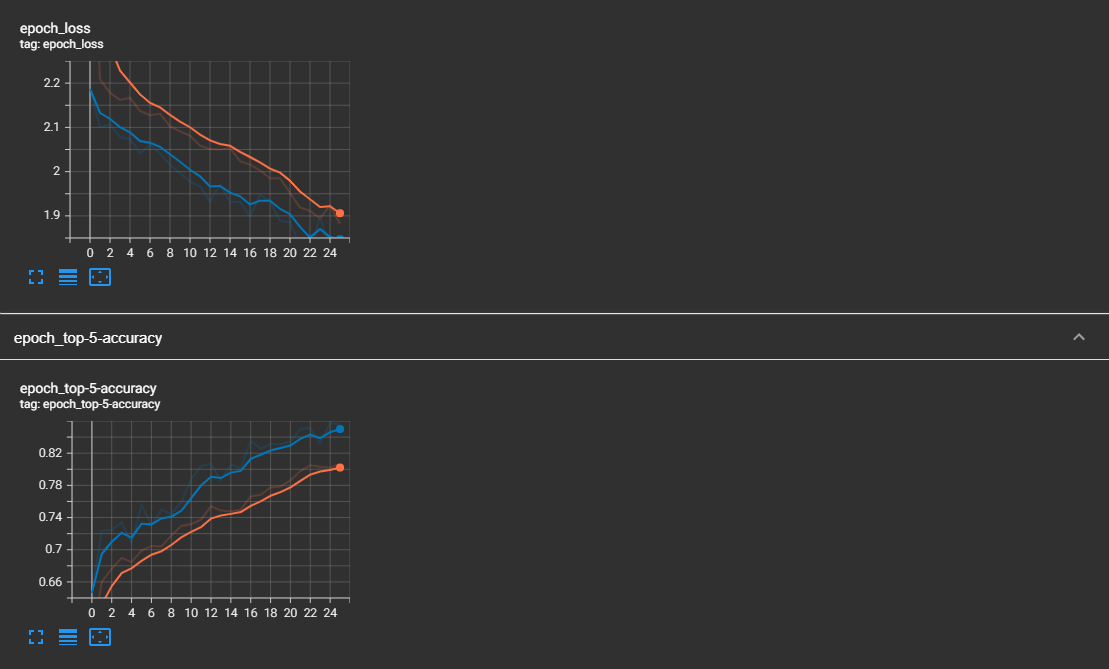

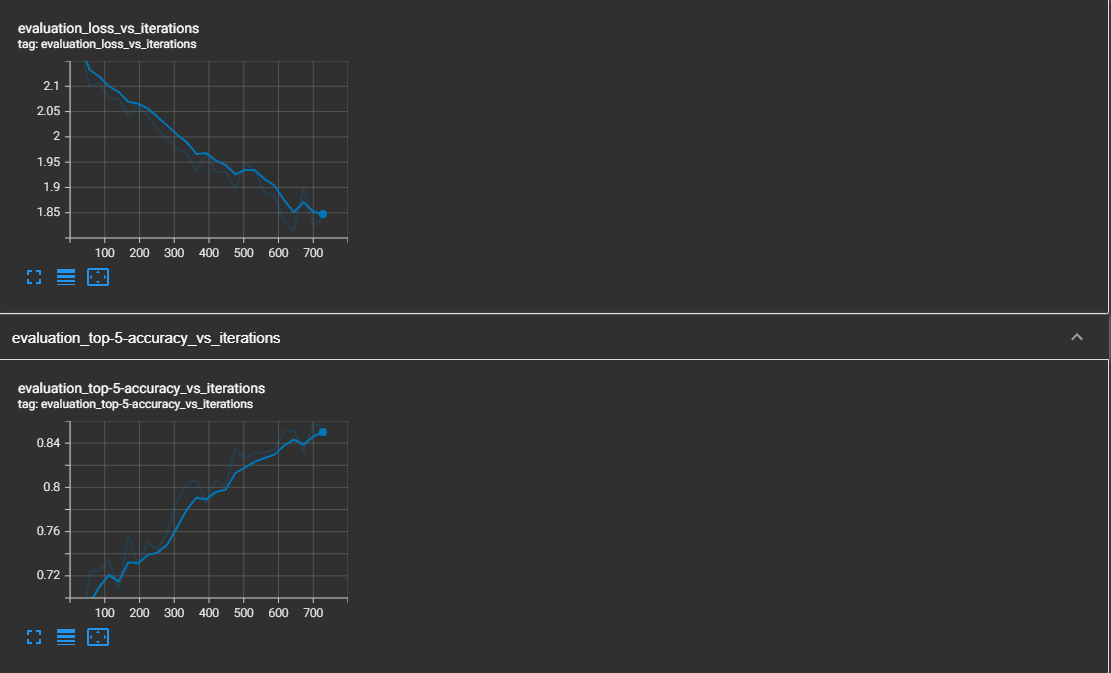

Found 1387 images belonging to 10 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1/1 [==============================] - 5s 5s/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   alligator       0.28      0.10      0.15       130
    antelope       1.00      0.01      0.02        82
  bald eagle       0.84      0.09      0.17       169
        bear       0.30      0.52      0.38       185
       bison       0.38      0.46      0.41       169
     cheetah       0.34      0.43      0.38       147
      condor       0.53      0.30      0.38       169
     giraffe       0.00      0.00      0.00        99
     manatee       0.85      0.60      0.71        88
       zebra       0.22      0.66      0.33       149

    accuracy                           0.34      1387
   macro avg       0.47      0.32      0.29      1387
weighted avg       0.45      0.34      0.30      1387



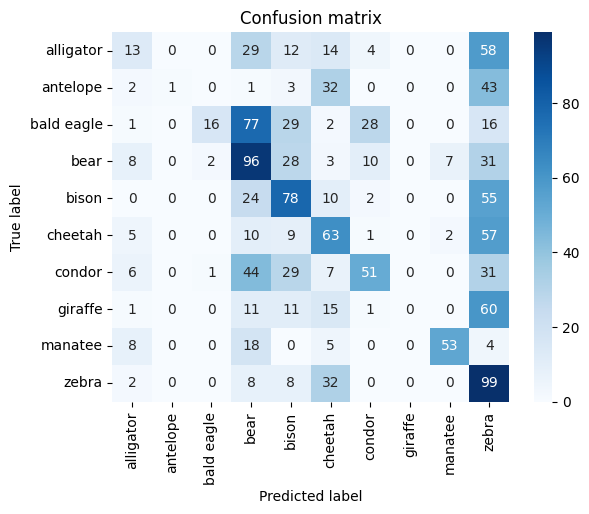

In [ ]:
eval_model(VITE)

In [ ]:
!zip -r "/content/logsVIT2(Smaller_MLP).zip" "/content/logsVIT2(Smaller_MLP)"

  adding: content/logsVIT2(Smaller_MLP)/ (stored 0%)
  adding: content/logsVIT2(Smaller_MLP)/train/ (stored 0%)
  adding: content/logsVIT2(Smaller_MLP)/train/events.out.tfevents.1681680716.a2f9f0dfc45c.442.0.v2 (deflated 90%)
  adding: content/logsVIT2(Smaller_MLP)/validation/ (stored 0%)
  adding: content/logsVIT2(Smaller_MLP)/validation/events.out.tfevents.1681680763.a2f9f0dfc45c.442.1.v2 (deflated 78%)


In [ ]:

files.download('/content/logsVIT2(Smaller_MLP).zip')
files.download('/content/VIT2(Smaller_MLP).h5')
files.download('/content/history_VIT2(Smaller_MLP).pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  **Tuning Hyperprameters : Changing Number of Transformer Layers**

**Changing The Number of Transfromer Layers**
: We will try a smaller number of transformer layers , we will try 4 and see how it will affect the perforamce 

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
input_shape = (64, 64, 3)
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
#####################################
transformer_layers = 4
#####################################
mlp_head_units = [2048, 1024] 
num_classes = 10

In [ ]:
vit_classifier = create_vit_classifier()

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

checkpoint_callback = ModelCheckpoint(filepath='VIT(fewer transformer layers).h5',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      monitor='val_loss',
                                      verbose=1)

tensorboard_callback = TensorBoard(log_dir='./fewertransformerlayers')

vit_classifier.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        run_eagerly=True,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])


steps_per_epoch = len(train_generator)//batch_size

history =vit_classifier.fit(train_generator,validation_data = test_generator, batch_size = batch_size,epochs=num_epochs, callbacks=[tensorboard_callback,checkpoint_callback,early_stop])


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 4.3189 - accuracy: 0.1290 - top-5-accuracy: 0.5835
Epoch 1: val_loss improved from inf to 2.14451, saving model to VIT(fewer transformer layers).h5
28/28 [==============================] - 46s 2s/step - loss: 4.3189 - accuracy: 0.1290 - top-5-accuracy: 0.5835 - val_loss: 2.1445 - val_accuracy: 0.1911 - val_top-5-accuracy: 0.7030
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 2.2044 - accuracy: 0.1704 - top-5-accuracy: 0.6509
Epoch 2: val_loss improved from 2.14451 to 2.10490, saving model to VIT(fewer transformer layers).h5
28/28 [==============================] - 46s 2s/step - loss: 2.2044 - accuracy: 0.1704 - top-5-accuracy: 0.6509 - val_loss: 2.1049 - val_accuracy: 0.1853 - val_top-5-accuracy: 0.7239
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 2.1609 - accuracy: 0.1832 - top-5-accuracy: 0.6853
Epoch 3: val_loss improved from 2.10490 to 2.05908, saving model to VIT(fewe

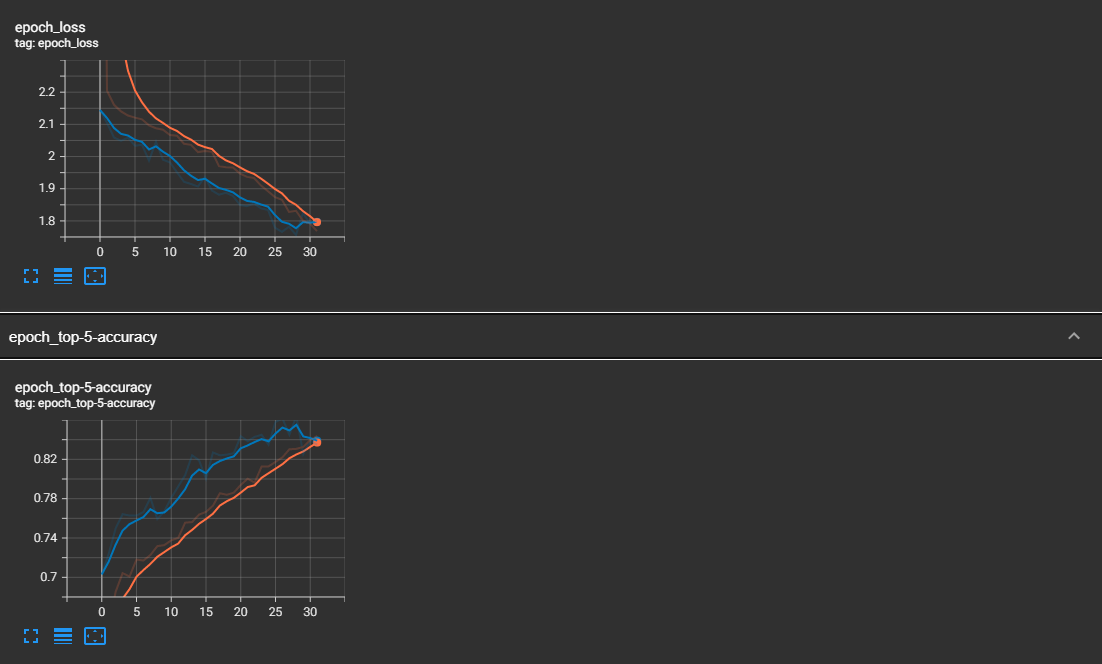

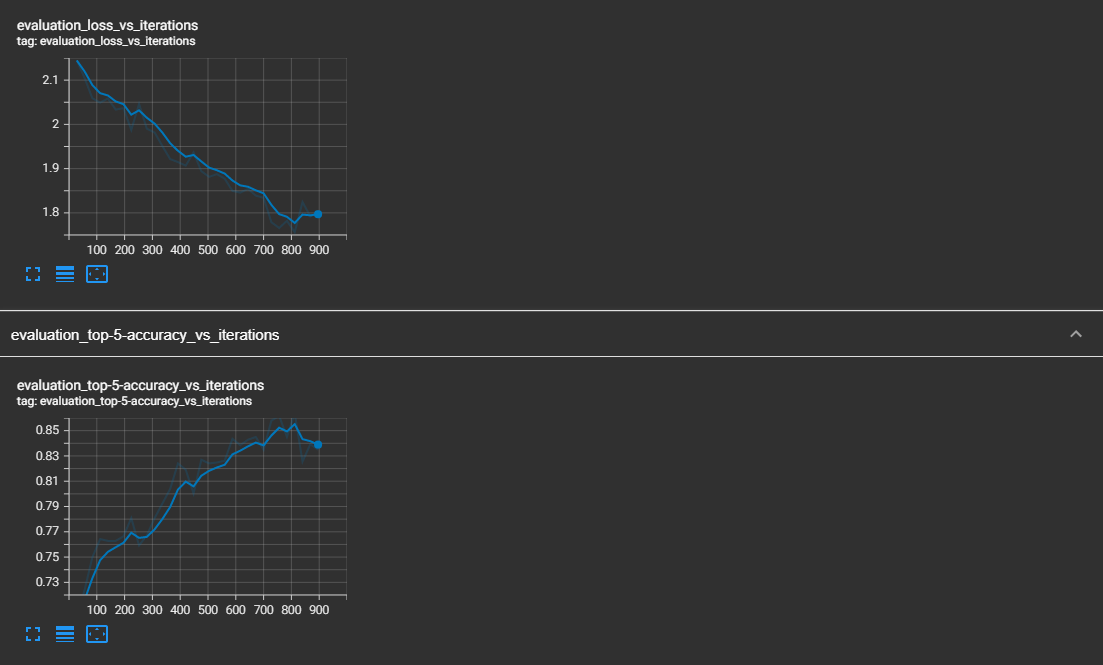

In [ ]:
with open('history_fewer transformer layers.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
VIFT = create_vit_classifier()
VIFT.load_weights('/content/VIT(fewer transformer layers).h5')
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
VIFT.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        run_eagerly=True,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

Found 1387 images belonging to 10 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1/1 [==============================] - 5s 5s/step
              precision    recall  f1-score   support

   alligator       0.27      0.16      0.20       130
    antelope       0.00      0.00      0.00        82
  bald eagle       0.42      0.64      0.51       169
        bear       0.30      0.45      0.36       185
       bison       0.42      0.57      0.49       169
     cheetah       0.32      0.43      0.37       147
      condor       0.53      0.18      0.27       169
     giraffe       0.24      0.08      0.12        99
     manatee       0.81      0.72      0.76        88
       zebra       0.43      0.52      0.47       149

    accuracy                           0.40      1387
   macro avg       0.37      0.37      0.35      1387
weighted avg       0.38      0.40      0.37      1387



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


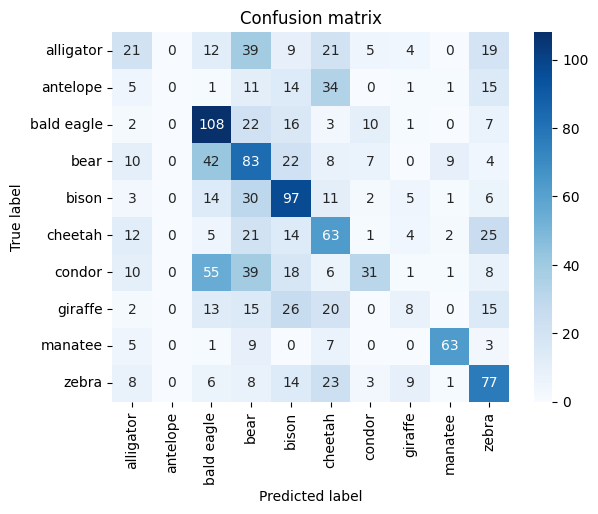

In [ ]:
eval_model(VIFT)

In [ ]:
!zip -r /content/fewertransformerlayers.zip /content/fewertransformerlayers
files.download('/content/fewertransformerlayers.zip')
files.download('/content/VIT(fewer transformer layers).h5')
files.download('/content/history_fewer transformer layers.pkl')

  adding: content/fewertransformerlayers/ (stored 0%)
  adding: content/fewertransformerlayers/train/ (stored 0%)
  adding: content/fewertransformerlayers/train/events.out.tfevents.1681682149.a2f9f0dfc45c.442.2.v2 (deflated 86%)
  adding: content/fewertransformerlayers/validation/ (stored 0%)
  adding: content/fewertransformerlayers/validation/events.out.tfevents.1681682190.a2f9f0dfc45c.442.3.v2 (deflated 79%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  **Tuning Hyperprameters : Changing Size of Patches**

**Changing The Number of Patches**
: We will try to increase the size of the patch and see how it will affect the perforamce 

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
input_shape = (64, 64, 3)
image_size = 64  # We'll resize input images to this size
###############################################
patch_size = 8  # Size of the patches to be extract from the input images
################################################
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 
num_classes = 10

In [ ]:
vit_classifier = create_vit_classifier()

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

checkpoint_callback = ModelCheckpoint(filepath='VITpatch_size.h5',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      monitor='val_loss',
                                      verbose=1)

tensorboard_callback = TensorBoard(log_dir='./Logspatch_size')

vit_classifier.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        run_eagerly=True,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])


steps_per_epoch = len(train_generator)//batch_size

history =vit_classifier.fit(train_generator,validation_data = test_generator, batch_size = batch_size,epochs=num_epochs, callbacks=[tensorboard_callback,checkpoint_callback,early_stop])

/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 3.9224 - accuracy: 0.1371 - top-5-accuracy: 0.5883
Epoch 1: val_loss improved from inf to 2.16535, saving model to VITpatch_size.h5
28/28 [==============================] - 50s 2s/step - loss: 3.9224 - accuracy: 0.1371 - top-5-accuracy: 0.5883 - val_loss: 2.1653 - val_accuracy: 0.1759 - val_top-5-accuracy: 0.7174
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 2.2079 - accuracy: 0.1698 - top-5-accuracy: 0.6587
Epoch 2: val_loss improved from 2.16535 to 2.08202, saving model to VITpatch_size.h5
28/28 [==============================] - 50s 2s/step - loss: 2.2079 - accuracy: 0.1698 - top-5-accuracy: 0.6587 - val_loss: 2.0820 - val_accuracy: 0.2329 - val_top-5-accuracy: 0.7426
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 2.1623 - accuracy: 0.1855 - top-5-accuracy: 0.6867
Epoch 3: val_loss improved from 2.08202 to 2.07816, saving model to VITpatch_size.h5
28/28 [================

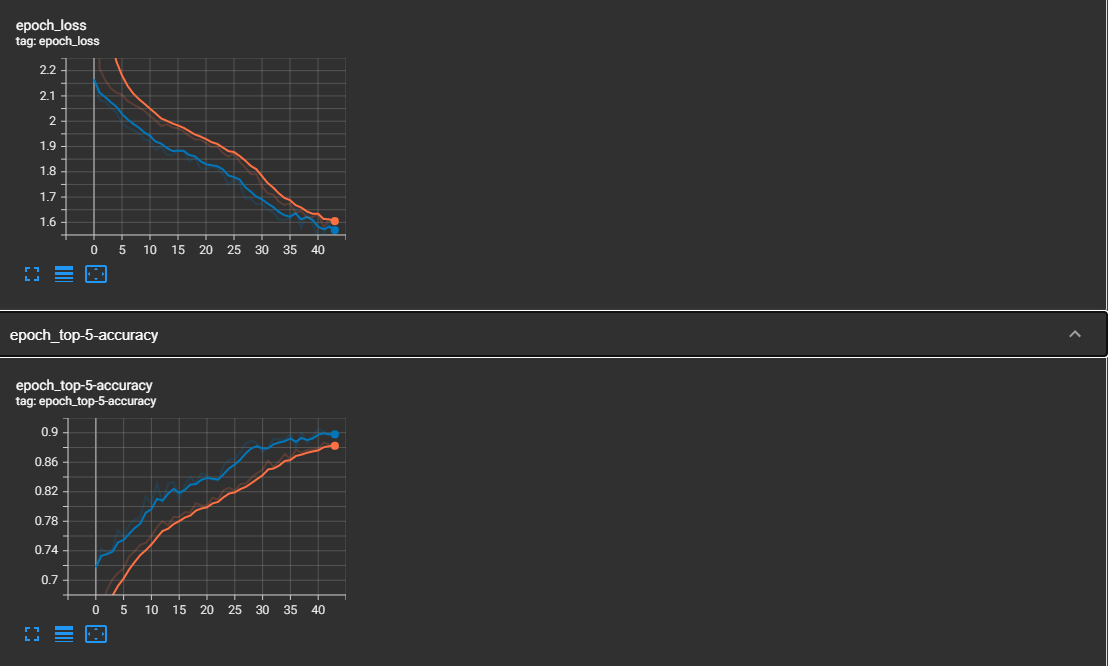

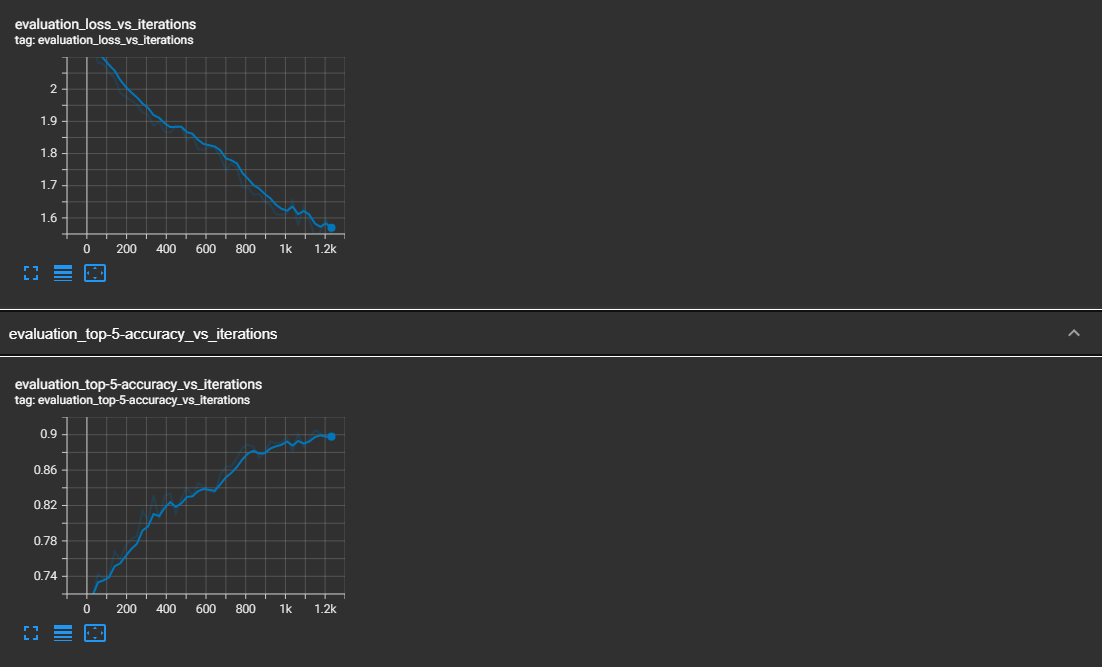

In [ ]:
with open('history_VITpatch_size.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
VITP = create_vit_classifier()
VITP.load_weights('/content/VITpatch_size.h5')
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
VITP.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        run_eagerly=True,
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

Found 1387 images belonging to 10 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1/1 [==============================] - 9s 9s/step
              precision    recall  f1-score   support

   alligator       0.32      0.23      0.27       130
    antelope       0.00      0.00      0.00        82
  bald eagle       0.70      0.42      0.53       169
        bear       0.41      0.58      0.48       185
       bison       0.66      0.53      0.59       169
     cheetah       0.33      0.74      0.46       147
      condor       0.45      0.40      0.43       169
     giraffe       0.30      0.06      0.10        99
     manatee       0.91      0.57      0.70        88
       zebra       0.46      0.74      0.57       149

    accuracy                           0.46      1387
   macro avg       0.45      0.43      0.41      1387
weighted avg       0.47      0.46      0.44      1387



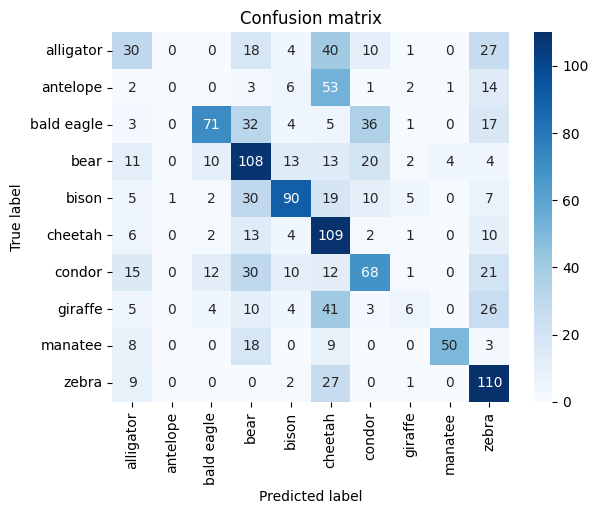

In [ ]:
eval_model(VITP)

In [ ]:
!zip -r /content/Logspatch_size.zip /content/Logspatch_size
files.download('/content/Logspatch_size.zip')
files.download('/content/VITpatch_size.h5')
files.download('/content/history_VITpatch_size.pkl')

  adding: content/Logspatch_size/ (stored 0%)
  adding: content/Logspatch_size/train/ (stored 0%)
  adding: content/Logspatch_size/train/events.out.tfevents.1681683828.a2f9f0dfc45c.442.4.v2 (deflated 89%)
  adding: content/Logspatch_size/validation/ (stored 0%)
  adding: content/Logspatch_size/validation/events.out.tfevents.1681683873.a2f9f0dfc45c.442.5.v2 (deflated 79%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Experimental Cells And Final Thoughts**

In [ ]:
df=pd.read_csv('eval.csv')
df

,Model,loss,accuracy,top-5-accuracy,val_loss,val_accuracy,val_top-5-accuracy,Epoch
0,BaseLine VIT,1.945006,0.285796,0.792409,1.850545,0.328046,0.841384,18
1,VIT(Fewer Transformer Layers),1.831471,0.332087,0.830650,1.756312,0.397260,0.863735,28
2,VIT(Larger LR),14.138749,0.131685,0.604945,2.268421,0.133381,0.604903,1
3,VIT(Larger Number of Patch Size),1.634471,0.423376,0.878235,1.541043,0.462149,0.904831,40
4,VIT(Fewer MLP Units),1.910997,0.293560,0.804917,1.814511,0.338861,0.851478,22


The VIT with a larger number of patch size perfomrmed fairly well when compared to other VITs keep in mind to get btter predictions and get better classification metrics , a VIT must be first pretrianed on a larger dataset and then finetuned on a smaller one

In [ ]:
preds = sorted(os.listdir('ImageNet/imagenet_images'))
preds_idx = [0,1,2,3,4,5,6,7,8,9]
preds = dict(zip(preds_idx,preds))
preds

{0: 'alligator',
 1: 'antelope',
 2: 'bald eagle',
 3: 'bear',
 4: 'bison',
 5: 'cheetah',
 6: 'condor',
 7: 'giraffe',
 8: 'manatee',
 9: 'zebra'}

1/1 [==============================] - 0s 239ms/step


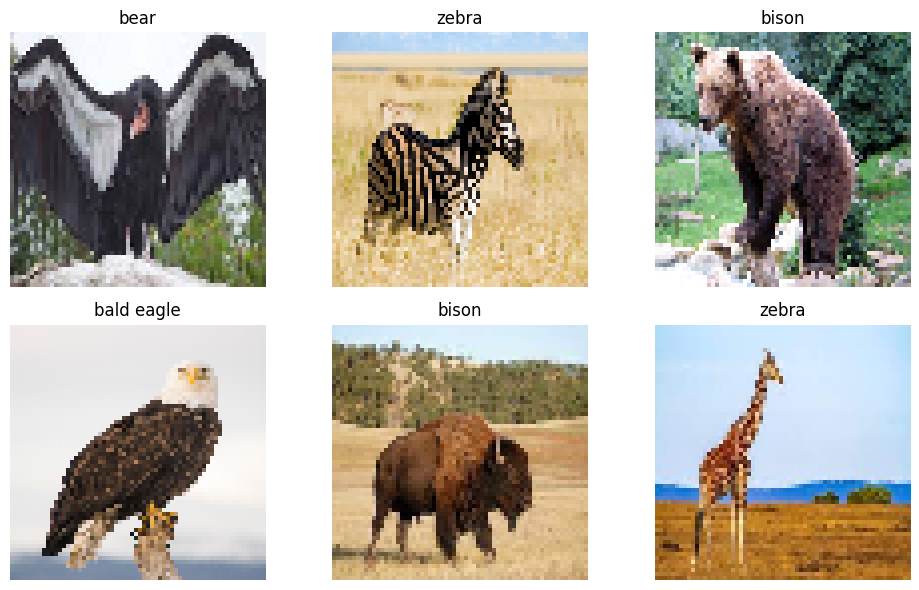

In [ ]:
dir_path = '/content/Predictions'
num_rows = 2
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i, filename in enumerate(os.listdir(dir_path)):
    img_path = os.path.join(dir_path, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))

    yhat = VITP.predict(np.expand_dims(img, 0))
    label = preds[yhat.argmax()]

    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(img)
    axs[row, col].set_title(label)
    axs[row, col].axis('off')

plt.tight_layout()

plt.show()